# Top of NB

In [1]:
import pandas as pd
from pathlib import Path
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set_theme()
import sys
import xlwings as xw

# Set the main project folder to python path so we can import our homemade modules
PROJECT_FOLDER = Path().absolute().parent
sys.path.append(str(PROJECT_FOLDER))

from game_mechanics.engine import DataBase
import game_mechanics as gm 

# Data Load

In [2]:
DATA_FOLDER = PROJECT_FOLDER / 'data'
DATA_FILE = DATA_FOLDER / 'master_db.json'
db = DataBase(DATA_FILE)
print(f'Data size: {len(db.data)}')

Data size: 62626


In [3]:
raw_data = pd.DataFrame(db.data)
print(raw_data.shape)
raw_data.head(2)

(62626, 9)


,game_id,player_one_id,player_two_id,winner_id,first_mover_id,moves,turns,start_time,end_time
0,1731877338926014-313026-dfd03d46,monte_carlo_50,monte_carlo_200,monte_carlo_200,monte_carlo_50,"[2, 5, 2, 4, 0, 3, 6, 2, 4, 3, 3, 5, 3, 5, 5, ...",42,NaN,NaN
1,1731877383226884-899336-1e5dcfb5,random_naive,monte_carlo_500,monte_carlo_500,random_naive,"[3, 3, 6, 3, 1, 3, 2, 3]",8,NaN,NaN


# Data Clean

In [4]:
data_df_1 = raw_data.copy()

# Add indicator variable if player one is the winner
data_df_1['player_one_win'] = data_df_1.winner_id == data_df_1.player_one_id

print(data_df_1.shape)
data_df_1.head(2)

(62626, 10)


,game_id,player_one_id,player_two_id,winner_id,first_mover_id,moves,turns,start_time,end_time,player_one_win
0,1731877338926014-313026-dfd03d46,monte_carlo_50,monte_carlo_200,monte_carlo_200,monte_carlo_50,"[2, 5, 2, 4, 0, 3, 6, 2, 4, 3, 3, 5, 3, 5, 5, ...",42,NaN,NaN,False
1,1731877383226884-899336-1e5dcfb5,random_naive,monte_carlo_500,monte_carlo_500,random_naive,"[3, 3, 6, 3, 1, 3, 2, 3]",8,NaN,NaN,False


In [5]:
data_df_1.tail(2)

,game_id,player_one_id,player_two_id,winner_id,first_mover_id,moves,turns,start_time,end_time,player_one_win
62624,1732806409274295-273747-25fb7183,monte_carlo_100,monte_carlo_51,monte_carlo_100,monte_carlo_100,"[3, 3, 2, 1, 4, 5, 2, 2, 3, 0, 6, 1, 3, 1, 1, ...",25,2024-11-28T09:06:49.274295,2024-11-28T09:06:55.535230,True
62625,1732806415536368-218120-39e6c59e,monte_carlo_200,monte_carlo_50,monte_carlo_200,monte_carlo_200,"[3, 1, 4, 3, 5, 2, 6]",7,2024-11-28T09:06:55.536368,2024-11-28T09:06:59.202924,True


## Quick Game Validation
Pick a game to make sure it's gameplay sequence looks legit.

In [6]:
# # Random Game
# random_int = np.random.randint(0, len(data_df_1))
# game = data_df_1.iloc[random_int]

# # Or manual override game
# game = data_df_1.iloc[59620]

# # Grab the moves from this game and create a sequence of boards from those moves
# boards = gm.Board.make_boards_from_moves(game.moves)

# # Display the game unfolding:
# print(f'Player 1: {game.player_one_id} vs Player 2: {game.player_two_id}. Winner: {game.winner_id}. (Game Int: {game.name})')

# for board in boards:
#     board.display_board()

# EDA

In [7]:
print(f'There are {len(data_df_1)} games in the dataset.')

There are 62626 games in the dataset.


In [8]:
data_df_1['num_moves'] = data_df_1.moves.apply(len)
total_moves = data_df_1.num_moves.sum()
print(f'Total moves: {total_moves:,}')

Total moves: 1,139,648


## Playtime Frequency

In [9]:
unique_players = [
    'random_naive',
    'random_not_stupid',    
    'monte_carlo_50',
    'monte_carlo_51',
    'monte_carlo_100',
    'monte_carlo_150',
    'monte_carlo_200',
    'monte_carlo_500',
    'monte_carlo_1000',
]

data_set_players = sorted(list(set(data_df_1.player_one_id) | set(data_df_1.player_two_id)))
# Make sure the data sets overlap completely, print any issues
up_set = set(unique_players)
d_set = set(data_set_players)
assert up_set == d_set, f'Unique Players: {up_set} \n Data Set Players: {d_set}'

In [10]:
# Add a indicator column onto the dataframe indicating if that player played in the game
for player in unique_players:
    data_df_1[player] = (data_df_1.player_one_id == player) | (data_df_1.player_two_id == player)

play_counts = data_df_1[unique_players].sum()
play_counts = play_counts.sort_values(ascending=False)
play_counts

monte_carlo_150      36741
monte_carlo_200      28400
monte_carlo_50       27307
monte_carlo_51       14050
monte_carlo_100       8215
monte_carlo_500       4749
monte_carlo_1000      4635
random_not_stupid      601
random_naive           554
dtype: int64

<Axes: title={'center': 'Number of Games Played by Each Player'}>

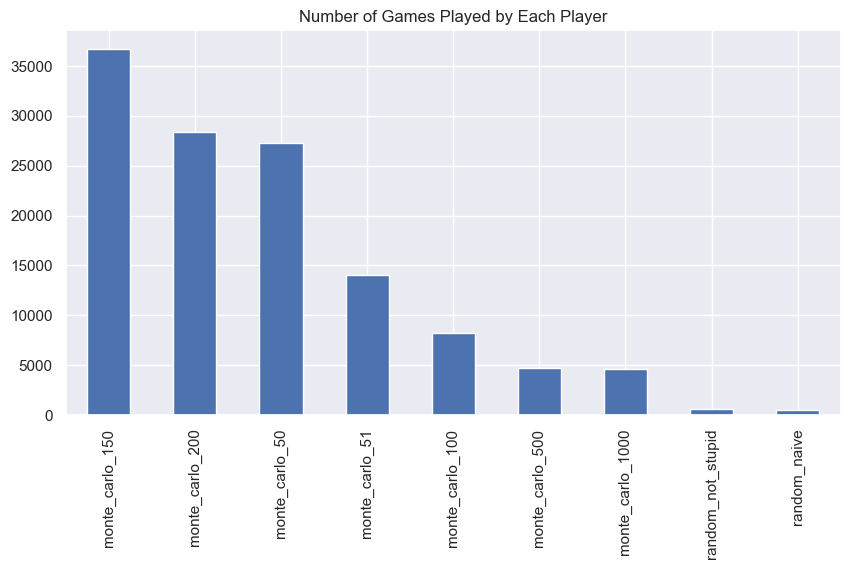

In [11]:
play_counts.plot(kind='bar', figsize=(10, 5), title='Number of Games Played by Each Player')

## Ties?

In [12]:
ties = (data_df_1.winner_id == 'Tie').sum()
print(f'There are {ties} tie games in the dataset.')

There are 816 tie games in the dataset.


## Player 1 Win?

In [13]:
data_df_1['player_one_win'] = data_df_1.winner_id == data_df_1.player_one_id
player_one_win_rate = data_df_1.player_one_win.mean()
print(f'Player One win rate: {player_one_win_rate:.2%}')

Player One win rate: 56.83%


## Best Bot?

In [14]:
games_played_df = pd.DataFrame(columns=unique_players, index=unique_players)
win_rates_df = pd.DataFrame(columns=unique_players, index=unique_players)

# Iterate through each each cell in the matrix and calculate the win rate of the row player against the column player
for row_player in unique_players:
    for col_player in unique_players:
        if row_player == col_player:
            continue

        mask = (data_df_1[row_player] & data_df_1[col_player])
        games_df = data_df_1[mask]
        games_played = len(games_df)
        row_player_wins = games_df.winner_id.eq(row_player).sum() / games_played 
        win_rates_df.loc[row_player, col_player] = row_player_wins
        games_played_df.loc[row_player, col_player] = games_played

win_rates_df
# games_played_df

C:\Users\User\AppData\Local\Temp\ipykernel_13488\2878580599.py:13: RuntimeWarning: invalid value encountered in scalar divide
  row_player_wins = games_df.winner_id.eq(row_player).sum() / games_played


,random_naive,random_not_stupid,monte_carlo_50,monte_carlo_51,monte_carlo_100,monte_carlo_150,monte_carlo_200,monte_carlo_500,monte_carlo_1000
random_naive,NaN,0.039216,0.0,NaN,0.0,NaN,0.0,0.0,0.0
random_not_stupid,0.960784,NaN,0.166667,NaN,0.132653,NaN,0.091954,0.095238,0.10084
monte_carlo_50,1.0,0.777778,NaN,0.491961,0.437301,0.389625,0.369193,0.318841,0.335121
monte_carlo_51,NaN,NaN,0.489531,NaN,0.425076,0.38565,0.386765,0.344239,0.325077
monte_carlo_100,1.0,0.846939,0.547652,0.565749,NaN,0.48449,0.455746,0.386889,0.416133
monte_carlo_150,NaN,NaN,0.599399,0.602392,0.503693,NaN,0.472663,0.436416,0.439759
monte_carlo_200,1.0,0.908046,0.612469,0.595588,0.531044,0.514253,NaN,0.467089,0.455243
monte_carlo_500,1.0,0.895238,0.673913,0.645804,0.604113,0.556358,0.525316,NaN,0.528662
monte_carlo_1000,1.0,0.89916,0.658177,0.664087,0.580026,0.554217,0.533248,0.470064,NaN


In [15]:
games_played_df

,random_naive,random_not_stupid,monte_carlo_50,monte_carlo_51,monte_carlo_100,monte_carlo_150,monte_carlo_200,monte_carlo_500,monte_carlo_1000
random_naive,NaN,102,83,0,84,0,105,68,112
random_not_stupid,102,NaN,90,0,98,0,87,105,119
monte_carlo_50,83,90,NaN,10698,4386,9658,818,828,746
monte_carlo_51,0,0,10698,NaN,654,669,680,703,646
monte_carlo_100,84,98,4386,654,NaN,677,757,778,781
monte_carlo_150,0,0,9658,669,677,NaN,24381,692,664
monte_carlo_200,105,87,818,680,757,24381,NaN,790,782
monte_carlo_500,68,105,828,703,778,692,790,NaN,785
monte_carlo_1000,112,119,746,646,781,664,782,785,NaN


In [16]:
# xw.view(win_rates_df)


In [17]:
# xw.view(games_played_df)